## VGG19
### Occlusion Test

VGG19, introduced by the Visual Geometry Group (Simonyan & Zisserman, 2014), is a deep convolutional neural network known for its simple yet effective architecture. It consists of 19 layers, including 16 convolutional layers and 3 fully connected layers, utilizing small 3x3 filters with a stride of 1 and 2x2 max-pooling layers. The model's depth allows it to learn hierarchical feature representations, making it well-suited for image classification tasks. Despite its straightforward design, VGG19 has shown excellent performance in large-scale image recognition benchmarks, serving as a foundation for various computer vision tasks such as object recognition and transfer learning.


Reference: Simonyan, K., & Zisserman, A. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv. https://arxiv.org/abs/1409.1556


In [6]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
device

device(type='cuda')

CIFAR-10 is a popular dataset used for training machine learning models, consisting of 60,000 32x32 color images in 10 different classes. In this section, we will load the CIFAR-10 dataset using TensorFlow and PyTorch. The dataset is split into 50,000 training images and 10,000 test images.

# Grid-based Occlusion
Inspired by: *Hide-and-Seek: A Data Augmentation Technique for Weakly-Supervised Localization and Beyond, Krishna Kumar Singh et al.*

I designed a simple algorithm that applies grid based random cutout of multiple patches in an image.

In [9]:
def grid_occlusion(img, grid_size, drop_prob):
    _, h, w = img.shape
    mask = torch.ones((h, w))

    for i in range(0, h, grid_size):
        for j in range(0, w, grid_size):
            if torch.rand(1).item() < drop_prob:
                mask[i:i+grid_size, j:j+grid_size] = 0

    img = img * mask
    return img

class GridOcclusionTransform:
    def __init__(self, grid_size=4, drop_prob=0.2):
        self.grid_size = grid_size
        self.drop_prob = drop_prob

    def __call__(self, img):
        return grid_occlusion(img, self.grid_size, self.drop_prob)


def data_loader(data_dir,
                    batch_size,
                    random_seed=42,
                    valid_size=0.1,
                    shuffle=True,
                    test=False):

        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),
            normalize,
        ])
        transform_test = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            GridOcclusionTransform(),

            normalize,
        ])
        download = not os.path.exists(os.path.join(data_dir, "cifar-10-batches-py"))
        print(download)
        if test:
            dataset = datasets.CIFAR10(
              root=data_dir, train=False,
              download=download, transform=transform_test,
            )

            data_loader = torch.utils.data.DataLoader(
                dataset, batch_size=batch_size, shuffle=shuffle
            )

            return data_loader

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=download, transform=transform,
        )


        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(42)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler,num_workers=2,pin_memory=True)

        valid_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)
train_loader, valid_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                             batch_size=128)

test_loader = data_loader(data_dir='/kaggle/working/cifar10',
                                  batch_size=128,
                                  test=True)

False
False


The VGG19 class defines a convolutional neural network architecture based on the VGG model, with 19 layers, including convolutional and fully connected layers. In the __init__ method, the model is initialized with a sequence of convolutional layers followed by ReLU activations, and a classifier consisting of three fully connected layers. The architecture is designed using the _make_layer_set method, which constructs the network's layers based on the specified number of channels and repetitions. The network uses Kaiming initialization for the convolutional layers and normal initialization for the fully connected layers. The forward method passes the input through the layers, applies a flattening step, and outputs the classification results.

In [10]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG19, self).__init__()
        self.in_channels = 3

        # Convolutional layers (atomic definition without Sequential)
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu3_4 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu4_4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relu5_4 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(512, 4096)
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(4096, 4096)
        self.relu_fc2 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(4096, num_classes)

        # Weight initialization
        self._initialize_weights()

    def forward(self, x):
        x = self.relu1_1(self.conv1_1(x))
        x = self.relu1_2(self.conv1_2(x))
        x = self.pool1(x)

        x = self.relu2_1(self.conv2_1(x))
        x = self.relu2_2(self.conv2_2(x))
        x = self.pool2(x)

        x = self.relu3_1(self.conv3_1(x))
        x = self.relu3_2(self.conv3_2(x))
        x = self.relu3_3(self.conv3_3(x))
        x = self.relu3_4(self.conv3_4(x))
        x = self.pool3(x)

        x = self.relu4_1(self.conv4_1(x))
        x = self.relu4_2(self.conv4_2(x))
        x = self.relu4_3(self.conv4_3(x))
        x = self.relu4_4(self.conv4_4(x))
        x = self.pool4(x)

        x = self.relu5_1(self.conv5_1(x))
        x = self.relu5_2(self.conv5_2(x))
        x = self.relu5_3(self.conv5_3(x))
        x = self.relu5_4(self.conv5_4(x))
        x = self.pool5(x)

        x = x.view(x.size(0), -1)
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))
        x = self.fc3(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


The VGG19 model, originally designed for the ImageNet dataset, employs a deep architecture with 19 layers, including 16 convolutional layers and 3 fully connected layers. For training on the CIFAR-10 dataset on our limited GPU resources adjustments to hyperparameters are necessary to optimize performance. Modifications include reducing the learning rate, decreasing the number of epochs.

We also use lr scheduler instead of manually adjusting lr(Practiced orginally).


In [ ]:
num_classes = 10
num_epochs = 10
learning_rate = 0.01

model = VGG19()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[3],
                                               gamma=0.1)

total_step = len(train_loader)

In [12]:
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
drive.mount('/content/drive')

Mounted at /content/drive


The training loop includes model checkpointing, which saves the model, optimizer, and scheduler states every two epochs to allow resuming training if interrupted. It also implements early stopping based on validation accuracy, halting training after three consecutive epochs of no improvement. Additionally, the loop ensures efficient memory management by clearing tensors and invoking garbage collection after each batch.

In [ ]:
import gc
import time

checkpoint_path = "/content/vgg19_occulusion_10.pth"


start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
loss_info = {'train':[], 'val':[]}
for epoch in range(start_epoch, num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):

        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"vgg19_occulusion_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, Train loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: {:.2f}".format( time.time()-t))
    loss_info['train'].append(loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        loss_total = 0
        batch_size = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size+=1

        loss_avg = loss_total/batch_size
        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.4f}%    Val loss: {loss_avg: .2f}')
        loss_info['val'].append(loss_avg)


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

epoch 1, Train loss: 2.1120
Time: 106.85
Val acc: 21.9600%    Val loss:  2.09
Checkpoint saved at epoch 2
epoch 2, Train loss: 1.8299
Time: 114.60
Val acc: 28.8000%    Val loss:  1.87
epoch 3, Train loss: 1.5221
Time: 106.15
Val acc: 31.9800%    Val loss:  1.77
Checkpoint saved at epoch 4
epoch 4, Train loss: 1.5270
Time: 112.63
Val acc: 40.7000%    Val loss:  1.56
epoch 5, Train loss: 1.3600
Time: 106.83
Val acc: 44.6600%    Val loss:  1.45
Checkpoint saved at epoch 6
epoch 6, Train loss: 1.2892
Time: 108.65
Val acc: 47.5400%    Val loss:  1.43
epoch 7, Train loss: 1.0791
Time: 104.89
Val acc: 54.6800%    Val loss:  1.22
Checkpoint saved at epoch 8
epoch 8, Train loss: 1.0859
Time: 114.10
Val acc: 56.1800%    Val loss:  1.19
epoch 9, Train loss: 1.3505
Time: 104.71
Val acc: 57.2800%    Val loss:  1.16
Checkpoint saved at epoch 10
epoch 10, Train loss: 1.0881
Time: 107.84
Val acc: 57.1600%    Val loss:  1.16


Since the first 10 epochs were unsatisfactory, we will train for five more.

In [15]:
import gc
import time

checkpoint_path = "/content/vgg19_occulusion_10.pth"

num_epochs = 5
start_epoch = 11
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    start_epoch = checkpoint["epoch"] + 1
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch+1}")
total_step = len(train_loader)
best_val = -1
tolerance = 3
t = 0
loss_info = {'train':[], 'val':[]}
for epoch in range(start_epoch, start_epoch + num_epochs):
    t = time.time()
    for i, (images, labels) in enumerate(train_loader):

        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
    scheduler.step()
    if (epoch + 1) % 2 == 0:
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state":scheduler.state_dict()
        }, os.path.join(os.path.dirname(checkpoint_path), f"vgg19_occulusion_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")
    print ('epoch {}, Train loss: {:.4f}'.format(epoch+1, loss.item()))
    print("Time: {:.2f}".format( time.time()-t))
    loss_info['train'].append(loss.item())

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        loss_total = 0
        batch_size = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_size+=1

        loss_avg = loss_total/batch_size
        val_acc = 100 * correct / total
        print(f'Val acc: {val_acc:.4f}%    Val loss: {loss_avg: .2f}')
        loss_info['val'].append(loss_avg)


    if epoch > 0 and val_acc <= best_val:
        tolerance -= 1
        if tolerance == 0:
            print("early stopping")
            break
    else:
        best_val = val_acc
        tolerance = 3

Checkpoint loaded. Resuming from epoch 11
epoch 11, Train loss: 1.1810
Time: 110.68
Val acc: 57.4800%    Val loss:  1.16
Checkpoint saved at epoch 12
epoch 12, Train loss: 1.1091
Time: 114.48
Val acc: 58.5600%    Val loss:  1.11
epoch 13, Train loss: 1.0177
Time: 111.15
Val acc: 60.2000%    Val loss:  1.10
Checkpoint saved at epoch 14
epoch 14, Train loss: 1.0509
Time: 114.20
Val acc: 61.3000%    Val loss:  1.05
epoch 15, Train loss: 0.9431
Time: 110.91
Val acc: 62.2000%    Val loss:  1.06


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
      cm = confusion_matrix(y_true, y_pred)
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
      plt.xlabel('Predicted Label')
      plt.ylabel('True Label')
      plt.show()


### Check Original Model
We first test older model weights to analyze robustness on altered images. This model was trained on clean non-altered images.

Original loaded
Accuracy 24.07%


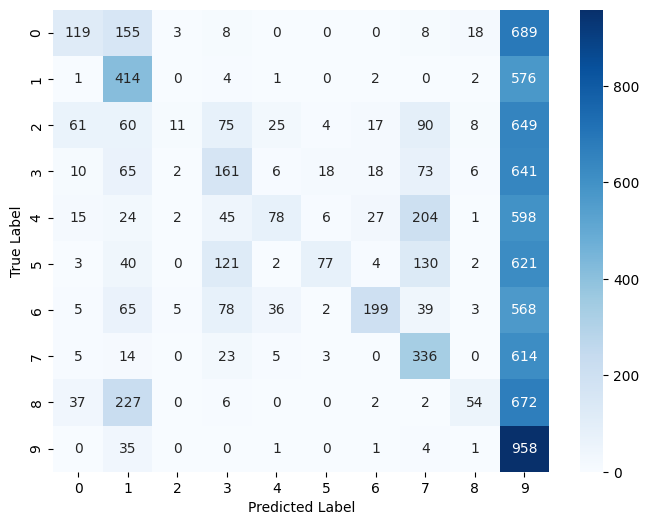

In [19]:
y_pred = []
y_true = []
model.eval()
checkpoint_path = "/content/vgg19_checkpoint3_9.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    print('Original loaded')
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs


print('Accuracy {}%'.format(100 * correct / total))
plot_confusion_matrix(y_true, y_pred, range(0,10))

### Check our new model

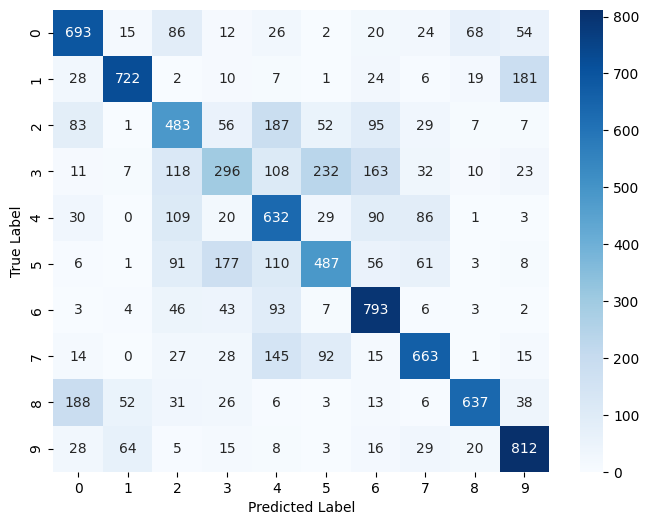

Accuracy 62.18%


In [ ]:
y_pred = []
y_true = []
model.eval()

# The newly trained model's checkpoint
checkpoint_path = "/content/drive/MyDrive/inception_10.pth"

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        model.to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

plot_confusion_matrix(y_true, y_pred, range(0,10))
print('Accuracy {}%'.format(100 * correct / total))

# Scores

#### First, we check the original model's behaviour
*This model was trained in the past with clean/unaltered cifar10 images.*
$$
\text{Pure Model Robustness} = \frac{\text{Accuracy on occluded images}}{\text{Accuracy on non-occluded images}}= 24.07 / 70.88 = 0.348
$$




#### Now, we check the newly trained model's improvement compared to original
*This will be indicative of the need to train on altered images.*
$$
\text{Trained Model Robustness Improvement} = \frac{\text{New model accuracy on occluded images}}{\text{Old model accuracy on occluded images}}= 62.18 / 24.07 = 2.58
$$

